In [2]:
import os
import json
import numpy as np
import nibabel as nib
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from lungmask import LMInferer
from utils.preprocessing import hu_data, convert_signed_4bit_to_hu, convert_to_signed_4bit
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import clear_border

from utils.registration import ElastixTransformix
from utils.datasets import read_raw
from utils.utils import parse_transformed_points
from utils.vis import plot_images, plot_images_sitk
from utils.metrics import target_registration_error
from utils.vis import plot_images_nib, plot_images, analyze_inhale_exhale, plot_slice
from utils.preprocessing import flatten_peak_in_range, convert_signed_4bit_to_unsigned_8bit
from utils.segment import apply_lungmask_binary, apply_lungmask_thresholded

In [3]:
DATA_PATH = './data_test'
RESULT_PATH = './results'
PARAMETER_PATH = './parameter'
ELASTIX_PATH = './elastix'
MASK_PATH = './mask_test'
DATA_PATH_4BIT = './data_4bit'
submit_path = './submit'
dataset_info = json.load(open("./data/dataset_info.json"))
save = True

# Converting and saving .nii.gz


Processing copd1
Information: Size: [512, 512, 121], Spacing: [0.625, 0.625, 2.5], Displacement: Mean - 25.9 Std - 11.57
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 121\n', b'ElementSpacing = 0.625 0.625 2.5\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 -1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd1/copd1_iBHCT.img\n']
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 121\n', b'ElementSpacing = 0.625 0.625 2.5\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 -1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd1/copd1_eBHCT.img\n']


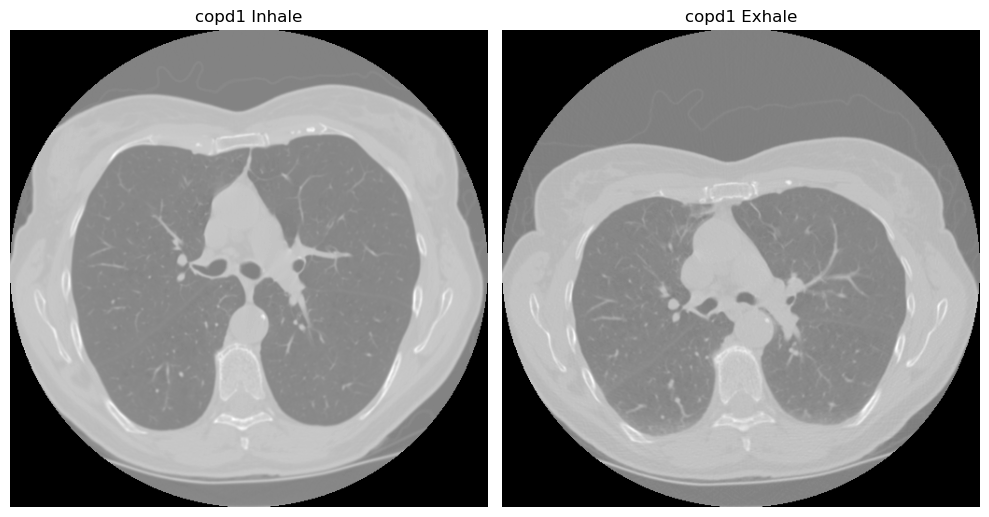

Processing copd2
Information: Size: [512, 512, 102], Spacing: [0.645, 0.645, 2.5], Displacement: Mean - 21.77 Std - 6.46
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 102\n', b'ElementSpacing = 0.645 0.645 2.5\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 -1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd2/copd2_iBHCT.img\n']
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 102\n', b'ElementSpacing = 0.645 0.645 2.5\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 -1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd2/copd2_eBHCT.img\n']


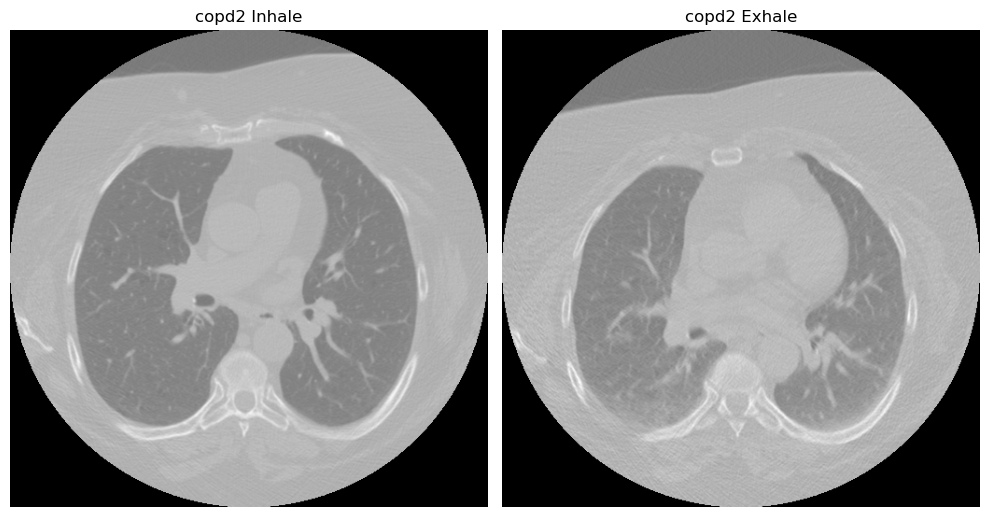

Processing copd3
Information: Size: [512, 512, 126], Spacing: [0.652, 0.652, 2.5], Displacement: Mean - 12.29 Std - 6.39
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 126\n', b'ElementSpacing = 0.652 0.652 2.5\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 -1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd3/copd3_iBHCT.img\n']
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 126\n', b'ElementSpacing = 0.652 0.652 2.5\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 -1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd3/copd3_eBHCT.img\n']


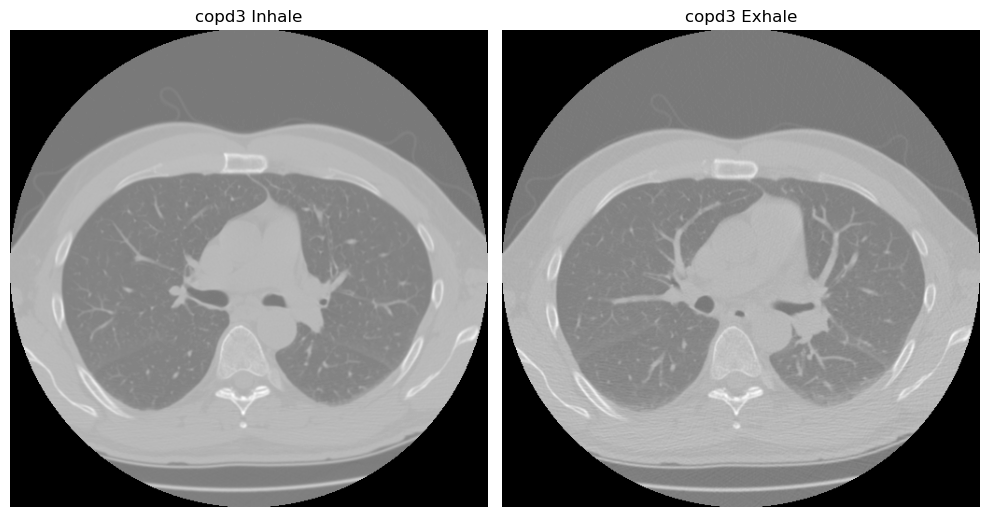

Processing copd4
Information: Size: [512, 512, 126], Spacing: [0.59, 0.59, 2.5], Displacement: Mean - 30.9 Std - 13.49
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 126\n', b'ElementSpacing = 0.59 0.59 2.5\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 -1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd4/copd4_iBHCT.img\n']
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 126\n', b'ElementSpacing = 0.59 0.59 2.5\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 -1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd4/copd4_eBHCT.img\n']


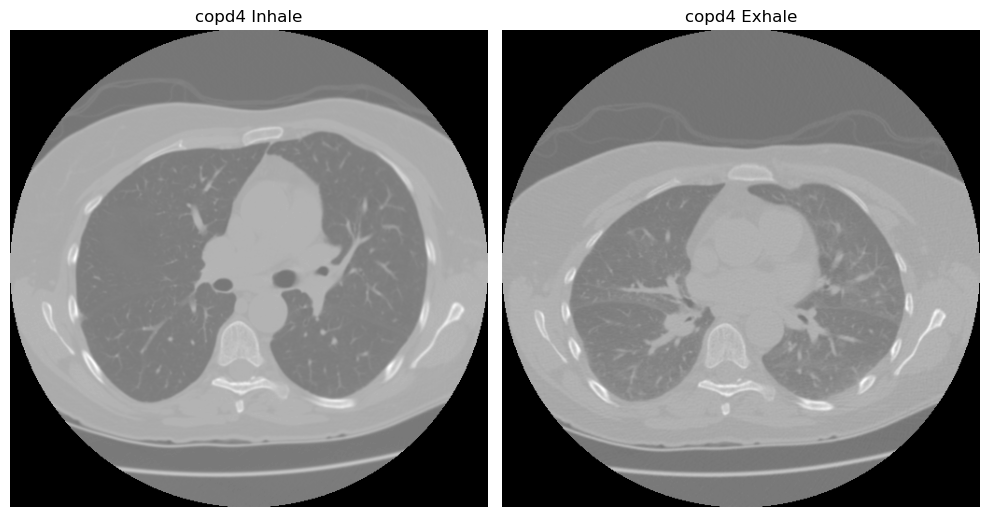

In [3]:
for key, value in dataset_info.items():
    print(f"Processing {key}")

    ## Read the images
    inhale_image_path = os.path.join(DATA_PATH, key, f'{key}_iBHCT.img')
    exhale_image_path = os.path.join(DATA_PATH, key, f'{key}_eBHCT.img')
    
    ## Read the metadata
    size = value["size"]
    spacing = value["spacing"]
    disp_mean = value["disp_mean"]
    disp_std = value["disp_std"]
    print(f"Information: Size: {size}, Spacing: {spacing}, Displacement: Mean - {disp_mean} Std - {disp_std}")
    
    # Read the image using both big and little endian
    inhale_image = read_raw(
        binary_file_name=inhale_image_path,
        image_size=size,
        image_spacing=spacing,
        sitk_pixel_type=sitk.sitkInt16,
    )
    exhale_image = read_raw(
        binary_file_name=exhale_image_path,
        image_size=size,
        image_spacing=spacing,
        sitk_pixel_type=sitk.sitkInt16,
    )

    ## Export the images to nii.gz
    if save == True:
        inhale_export_path = inhale_image_path.replace(".img", ".nii.gz")
        exhale_export_path = exhale_image_path.replace(".img", ".nii.gz")
        sitk.WriteImage(inhale_image, inhale_export_path)
        sitk.WriteImage(exhale_image, exhale_export_path)
    
    ## Plot the images
    plot_images_sitk([inhale_export_path, exhale_export_path], titles=[f"{key} Inhale", f"{key} Exhale"], cols=2, slice_idx=50, fig_size=(10, 10))

# Preprocessing for all Images

In [4]:
for key, value in dataset_info.items():
    print(f"Processing {key}")
    
    ## Read the images
    inhale_image_path = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
    exhale_image_path = os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz')
    lung_inhale_export_path = os.path.join(MASK_PATH, key)
    lung_exhale_export_path = os.path.join(MASK_PATH, key)
        
    inhale_image = nib.load(inhale_image_path)
    inhale_data = inhale_image.get_fdata()
    exhale_image = nib.load(exhale_image_path)
    exhale_data = exhale_image.get_fdata()

    ## Preprocess the images
    hu_inhale = hu_data(inhale_data)
    hu_exhale = hu_data(exhale_data)

    inhale_bit_4 = convert_to_signed_4bit(hu_inhale)
    exhale_bit_4 = convert_to_signed_4bit(hu_exhale)

    inhale_bit_4_hu = convert_signed_4bit_to_hu(inhale_bit_4)
    exhale_bit_4_hu = convert_signed_4bit_to_hu(exhale_bit_4)

    lung_inhale = apply_lungmask_binary(inhale_data)
    lung_exhale = apply_lungmask_binary(exhale_data)

    lung_inhale_threholded = apply_lungmask_thresholded(inhale_data)
    lung_exhale_threholded = apply_lungmask_thresholded(exhale_data)

    lung_inhale_combined = np.bitwise_and(lung_inhale, lung_inhale_threholded)
    lung_exhale_combined = np.bitwise_and(lung_exhale, lung_exhale_threholded)

    # Export 4-bit hu images
    inhale_4bit_export_path = os.path.join(DATA_PATH_4BIT, key)
    exhale_4bit_export_path = os.path.join(DATA_PATH_4BIT, key)
    os.makedirs(inhale_4bit_export_path, exist_ok=True)
    os.makedirs(exhale_4bit_export_path, exist_ok=True)
    inhale_4bit_hu = nib.Nifti1Image(inhale_bit_4_hu, inhale_image.affine)
    exhale_4bit_hu = nib.Nifti1Image(exhale_bit_4_hu, exhale_image.affine)
    nib.save(inhale_4bit_hu, os.path.join(inhale_4bit_export_path, f'{key}_iBHCT_4bit.nii.gz'))
    nib.save(exhale_4bit_hu, os.path.join(exhale_4bit_export_path, f'{key}_eBHCT_4bit.nii.gz'))

    ## Export the lung masks
    lung_inhale_export_path = os.path.join(MASK_PATH, key)
    lung_exhale_export_path = os.path.join(MASK_PATH, key)
    os.makedirs(lung_inhale_export_path, exist_ok=True)
    os.makedirs(lung_exhale_export_path, exist_ok=True)
    lung_inhale_nib = nib.Nifti1Image(lung_inhale, inhale_image.affine)
    lung_exhale_nib = nib.Nifti1Image(lung_exhale, exhale_image.affine)
    nib.save(lung_inhale_nib, os.path.join(lung_inhale_export_path, f'{key}_iBHCT_lung_mask.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)
    nib.save(lung_exhale_nib, os.path.join(lung_exhale_export_path, f'{key}_eBHCT_lung_mask.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)

    ## Export the thresholded lung masks
    lung_inhale_thresholded_export_path = os.path.join(MASK_PATH, key)
    lung_exhale_thresholded_export_path = os.path.join(MASK_PATH, key)
    os.makedirs(lung_inhale_thresholded_export_path, exist_ok=True)
    os.makedirs(lung_exhale_thresholded_export_path, exist_ok=True)
    lung_inhale_thresholded_nib = nib.Nifti1Image(lung_inhale_threholded, inhale_image.affine)
    lung_exhale_thresholded_nib = nib.Nifti1Image(lung_exhale_threholded, exhale_image.affine)
    nib.save(lung_inhale_thresholded_nib, os.path.join(lung_inhale_thresholded_export_path, f'{key}_iBHCT_lung_mask_thresholded.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)    
    nib.save(lung_exhale_thresholded_nib, os.path.join(lung_exhale_thresholded_export_path, f'{key}_eBHCT_lung_mask_thresholded.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)   

    ## Export the combined lung masks
    lung_inhale_combined_export_path = os.path.join(MASK_PATH, key)
    lung_exhale_combined_export_path = os.path.join(MASK_PATH, key)
    os.makedirs(lung_inhale_combined_export_path, exist_ok=True)
    os.makedirs(lung_exhale_combined_export_path, exist_ok=True)
    lung_inhale_combined_nib = nib.Nifti1Image(lung_inhale_combined, inhale_image.affine)
    lung_exhale_combined_nib = nib.Nifti1Image(lung_exhale_combined, exhale_image.affine)
    nib.save(lung_inhale_combined_nib, os.path.join(lung_inhale_combined_export_path, f'{key}_iBHCT_lung_mask_combined.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)
    nib.save(lung_exhale_combined_nib, os.path.join(lung_exhale_combined_export_path, f'{key}_eBHCT_lung_mask_combined.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)

Processing copd1
lungmask 2025-01-09 20:26:51 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


7it [00:13,  1.91s/it]                          

lungmask 2025-01-09 20:27:07 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 400.89it/s]


lungmask 2025-01-09 20:27:09 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


7it [00:13,  1.89s/it]                          

lungmask 2025-01-09 20:27:24 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 468.24it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd2
lungmask 2025-01-09 20:27:40 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


6it [00:08,  1.41s/it]                         

lungmask 2025-01-09 20:27:50 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 431.58it/s]


lungmask 2025-01-09 20:27:52 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


6it [00:10,  1.68s/it]                         

lungmask 2025-01-09 20:28:03 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 1410.32it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd3
lungmask 2025-01-09 20:28:17 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


7it [00:09,  1.40s/it]                         

lungmask 2025-01-09 20:28:29 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 597.35it/s]


lungmask 2025-01-09 20:28:32 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


7it [00:11,  1.61s/it]                         

lungmask 2025-01-09 20:28:45 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 306.96it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd4
lungmask 2025-01-09 20:29:03 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


7it [00:11,  1.61s/it]                         

lungmask 2025-01-09 20:29:16 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 251.93it/s]


lungmask 2025-01-09 20:29:18 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


7it [00:11,  1.58s/it]                         

lungmask 2025-01-09 20:29:31 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 624.20it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************


# Resigtration with Mask

In [4]:
# Initialize the wrapper
elastix_transformix = ElastixTransformix(verbose=True, elastix_path=ELASTIX_PATH)
exp_mask = 'test'
result_path = './txt_results_mask_compare'
os.makedirs(result_path, exist_ok=True)
os.makedirs(submit_path, exist_ok=True)

for key, value in dataset_info.items():

    print(f"Processing {key}")
    
    # Path to the text file for this image
    txt_file_path = f"{result_path}/{key}.txt"

    ## Read the images
    inhale_image = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
    exhale_image = os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz')
    inhale_mask = os.path.join(MASK_PATH, key, f'{key}_iBHCT_lung_mask_thresholded.nii.gz')
    exhale_mask = os.path.join(MASK_PATH, key, f'{key}_eBHCT_lung_mask_thresholded.nii.gz')
    
    # Paths
    parameter_files = [Path(f'{PARAMETER_PATH}/Par0056rigid.txt'), Path(f'{PARAMETER_PATH}/Par0016.multibsplines.lung.sliding_modified.txt'), Path(f'{PARAMETER_PATH}/Par_modified.txt')]
    # parameter_files = [Path(f'{PARAMETER_PATH}/Par0056rigid.txt')]

    exp = (os.path.basename(inhale_mask).split('.')[0]).replace('_iBHCT', '')
    res_path = os.path.join(RESULT_PATH, key, exp)
    os.makedirs(result_path, exist_ok=True)

    # Run Elastix
    transformation_file = elastix_transformix.run_elastix(
        fix_img_path=inhale_image,
        mov_img_path=exhale_image,
        res_path=res_path,
        parameters_paths=parameter_files,
        fix_mask_path=inhale_mask,
        mov_mask_path=exhale_mask
    )

    # Run Transformix (for points)
    inhale_points_file = Path(os.path.join(DATA_PATH, key, f'{key}_300_iBH_xyz_r1.txt'))
    elastix_transformix.run_transformix(
        mov_img_path=inhale_points_file,
        res_path=res_path,
        transformation_path=transformation_file,
        points=True
    )
    
    transformed_points_file = Path(os.path.join(res_path, f'{key}_300_iBH_xyz_r1_points.txt'))
    transformation_file_save = Path(os.path.join(submit_path, f'{key}_transformed.txt'))
    inhale_points, transformed_inhale_points = parse_transformed_points(transformed_points_file, transformation_file_save)
    
    
    print(f'{key} transformed points saved')

Processing copd1
Running command: ./elastix/elastix -out results/copd1/copd1_lung_mask_thresholded -f data/copd1/copd1_iBHCT.nii.gz -m data/copd1/copd1_eBHCT.nii.gz -fMask mask_test/copd1/copd1_iBHCT_lung_mask_thresholded.nii.gz -mMask mask_test/copd1/copd1_eBHCT_lung_mask_thresholded.nii.gz -p parameter/Par0056rigid.txt

elastix is started at Thu Jan  9 20:38:00 2025.

which elastix:   ./elastix/elastix
elastix runs at: Sumeets-MacBook-Air.local
  macOS 15.2 (x64), 24C101
  with 16384 MB memory, and 8 cores @ 2400 MHz.
-------------------------------------------------------------------------

Running elastix with parameter file 0: "parameter/Par0056rigid.txt".

Current time: Thu Jan  9 20:38:00 2025.
Reading the elastix parameters from file ...

Installing all components.
InstallingComponents was successful.

ELASTIX version: 5.000
Command line options from ElastixBase:
-f        data/copd1/copd1_iBHCT.nii.gz
-m        data/copd1/copd1_eBHCT.nii.gz
-fMask    mask_test/copd1/copd1_iBHC

# If error, then use this

In [ ]:
# Initialize the wrapper
elastix_transformix = ElastixTransformix(verbose=True, elastix_path=ELASTIX_PATH)
exp_mask = 'test'
result_path = './txt_results_mask_compare'
os.makedirs(result_path, exist_ok=True)
os.makedirs(submit_path, exist_ok=True)

for key, value in dataset_info.items():

    print(f"Processing {key}")
    
    # Path to the text file for this image
    txt_file_path = f"{result_path}/{key}.txt"

    ## Read the images
    inhale_image = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
    exhale_image = os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz')
    inhale_mask = os.path.join(MASK_PATH, key, f'{key}_iBHCT_lung_mask_thresholded.nii.gz')
    exhale_mask = os.path.join(MASK_PATH, key, f'{key}_eBHCT_lung_mask_thresholded.nii.gz')
    
    # Paths
    parameter_files = [Path(f'{PARAMETER_PATH}/Par0056rigid.txt'), Path(f'{PARAMETER_PATH}/Par_modified.txt'), Path(f'{PARAMETER_PATH}/Par0016.multibsplines.lung.sliding_modified.txt')]
    # parameter_files = [Path(f'{PARAMETER_PATH}/Par0016.multibsplines.lung.sliding_modified.txt')]

    exp = (os.path.basename(inhale_mask).split('.')[0]).replace('_iBHCT', '')
    res_path = os.path.join(RESULT_PATH, key, exp)
    os.makedirs(result_path, exist_ok=True)

    # Run Elastix
    transformation_file = elastix_transformix.run_elastix(
        fix_img_path=inhale_image,
        mov_img_path=exhale_image,
        res_path=res_path,
        parameters_paths=parameter_files,
        fix_mask_path=inhale_mask,
        mov_mask_path=exhale_mask
    )

    # Run Transformix (for points)
    inhale_points_file = Path(os.path.join(DATA_PATH, key, f'{key}_300_iBH_xyz_r1.txt'))
    elastix_transformix.run_transformix(
        mov_img_path=inhale_points_file,
        res_path=res_path,
        transformation_path=transformation_file,
        points=True
    )
    
    transformed_points_file = Path(os.path.join(res_path, f'{key}_300_iBH_xyz_r1_points.txt'))
    transformation_file_save = Path(os.path.join(submit_path, f'{key}_transformed.txt'))
    inhale_points, transformed_inhale_points = parse_transformed_points(transformed_points_file)
    
    print(f'{key} transformed points saved')